# LoRaDongle Data Analysis Notebook

# Useful Links:

1. [Select Row from DataFrame based on Column Value](https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values)
2. [Get Cell Value from Dataframe](https://sparkbyexamples.com/pandas/pandas-get-cell-value-from-dataframe/)

## Imports
Starts with importing the relevant packages

In [161]:
import csv, os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Global Variables
The variables that will be used in the notebook:
* List of the directories
* Data stored in a dictionary of lists, with the directories being keys and the list having csvs in a dataframe

In [162]:
data = {}
directories = ['latency_tests/','menzies_tests/','parkade_tests/', 'outdoor_cbd/', 'outdoor_forest/', 'outdoor_los/']

# Reading Information CSVs
(Will likely be more important for actual analysis)

In [163]:
#for i, directory in enumerate(directories):
#    csv_name = directory + 'tests_info.csv'
#    info[directory] = pd.read_csv(csv_name)

#info[directories[0]] = pd.read_csv('latency_tests/tests_info.csv')
#print(info)

latency_info =  pd.read_csv('latency_tests/tests_info.csv')
indoor_tests_info = pd.read_csv('parkade_tests/tests_info.csv')

# Reading Data CSVs
(probably not useful)

In [164]:
for i, directory in enumerate(directories):
    count = 0
    data[directory] = []
    for path in os.listdir(directory):
        # check if current path is a file
        if os.path.isfile(os.path.join(directory, path)):
            count += 1
        
    print(f'File count in {directory}:  {count}')

    #reading every csv, might need to keep track of test_number? or read csv indiviaidually!
    for j in range(1,count):
        csv_name = directories[i] + 'Test_' + str(j) + '.csv'
        #print(csv_name)
        data[directory].append(pd.read_csv(csv_name))
        


File count in latency_tests/:  7
File count in menzies_tests/:  14
File count in parkade_tests/:  20


FileNotFoundError: [Errno 2] No such file or directory: 'parkade_tests/Test_19.csv'

## Plan of action
With CSVs read, the goal is to print graphs for all the tests performed. Graphs should tell me things such as:
* Percentage of successful messages
* Average transmit latency
* Average Round Time Latencies
* Graph of SNRs and RSSIs


### New plan for reading and handling csvs
It seems like it would be easier to use tests_info.csv to iterate through CSVs in that folder and then extract the information you need from each csv. As opposed to reading all of them at once and struggling through.

## Latencies
Probably best to show it as a table. Should show max/min and average latency for each configuration! Therefore, iterate through csvs and get necessary data!

Basically create a new dataframe of read CSVs

### With New Plan
For every line in the read csv file (which is a test descriptor), read that test csv and extract the average, min and max latency. Store it in a new location

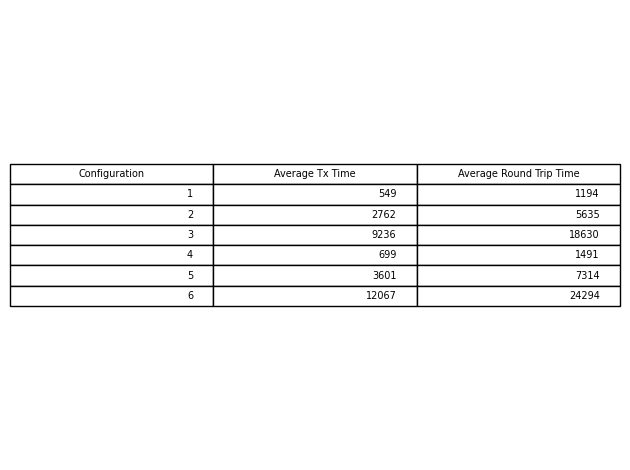

In [ ]:
latency_columns = ['Configuration', "Average Tx Time", "Average Round Trip Time"]#, "Max Tx Time", "Min Tx Time"]  #for now, configuration corresponds to test number, for latency testing there should really be only six tests
latency_results = {}

for column in latency_columns:
    latency_results[column] = []        #just initialising new data


#getting the list of tests (hence files) in the directory
tests = latency_info["Test Number"].tolist()

#opening and extracting necessary info per csv
for test_num in tests:

    test_config = latency_info.loc[latency_info["Test Number"] == test_num]["Configuration"]
    #print(test_config) TODO: get the config of the test number and then use that to append to latency results configuration list

    #start with adding the configuration to latency results
    latency_results['Configuration'].append(test_num)

    #reading current test csv
    csv_name =   "latency_tests/Test_" + str(test_num) + ".csv"
    test_csv = pd.read_csv(csv_name)

    #### Obtaining Average Tx
    average_latency = test_csv["Time to Send"].mean()
    #print(average_latency)
    #print(int(round(average_latency,0)))
    latency_results['Average Tx Time'].append(int(round(average_latency,0)))

    ### Obtaining Average Rx
    average_rx = test_csv["Time to Receive"].mean()
    latency_results['Average Round Trip Time'].append(int(round(average_rx,0)))

    #### Obtaining Max
    max_latency = test_csv["Time to Send"].max()
    #latency_results['Max Tx Time'].append(int(round(max_latency, 0)))


    #### Obtaining Min
    min_latency = test_csv["Time to Send"].min()
    #latency_results['Min Tx Time'].append(int(round(min_latency, 0)))


#convert results to dataframe
latency_df = pd.DataFrame.from_dict(latency_results)

###############################Plotting table####################################
# (Not that useful for final report)


#define figure and axes
fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')


#create table
table = ax.table(cellText=latency_df.values, colLabels=latency_df.columns, loc='center')

#display table
fig.tight_layout()
plt.show()

# Plans for Indoor testing analysis
Want to display the data as how each configuration responds due to the floor difference. So for example will look at a dloor differnce of two, will want to plot the % success rate of each configuration, the snr and rssi's of the configs as well.

Will tell me that yes looking at floor 3, configs 5-6 performed much better than configs 1-2.

Processing challenge will be:
1. Read info file
2. Filter by floor difference, horizontal distance
3. then filter by config
4. then read the test csvs of that config and that floor differnce
5. Pull the necessary data, appending it to whatever new dataframe that you have that will then plot the graphs.
6. Rinse and repeat

In [198]:
#print(indoor_tests_info)
success_rate_df = pd.DataFrame(columns = ["Config", "Success"])

# Starting with 1 floor difference
# Extract files info with 1 floor difference
floor_1_diff = indoor_tests_info.loc[indoor_tests_info["Floor Difference"] == 1]
print(floor_1_diff)
test_nums = floor_1_diff["Test Number"].tolist()
print(test_nums)

#print(floor_1_diff["Configuration"])

for test_num in test_nums:
    test_name = 'parkade_tests/Test_' + str(test_num) + ".csv"
    test_df = pd.read_csv(test_name)

    #start with calculating percentage of successful transmits
    #print(test_df['Success'].count())
    #TODO: assign config number to success_rate_df

    current_success_rate = test_df['Success'].value_counts(normalize=True) # obtain percentage of trues and falses
    #TODO Filter out to just trues
    try:
        current_success_rate = current_success_rate.drop("False", axis=1)
        print(current_success_rate)
        #pass
    except AttributeError:
        pass
    #current_success_rate = current_success_rate.drop(labels="False")
    #TODO remove column heading and just show data
    #print(current_success_rate)

    #success_rate_df.assign(current_success_rate)


    


    Test Number  Configuration  Floor Difference Location  LDRO
2             3              1                 1  Parkade     0
3             4              2                 1  Parkade     0
6             7              3                 1  Parkade     1
9            10              4                 1  Parkade     0
12           13              5                 1  Parkade     0
15           16              6                 1  Parkade     1
[3, 4, 7, 10, 13, 16]


ValueError: No axis named 1 for object type Series